In [769]:
from os import listdir
from os.path import isfile, join
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import re
import math
onlyfiles = [f for f in listdir(os.getcwd()) if isfile(join(os.getcwd(), f))]

In [770]:
# os.chdir("/home/seleythen/Pobrane")

In [771]:
classes = pandas.read_csv("classes_fos.csv", index_col=0)

In [772]:
schedulers_class = classes.loc[classes["modularity_class"] == 8]

In [780]:
schedulers_class["Id"].values

array([2639, 1368,  193,  689,  191,  199,  196,  198, 3850])

Read in publications from scheduling class.

In [774]:
def common_member(list_a, list_b):
    a_set = set(list_a)
    b_set = set(list_b)
    return len(a_set & b_set) > 0

def reader_fos(fileName, foses_class):
    df = pandas.read_json(fileName, lines=True)
    fos_with_nan_and_wages = df[["fos", "authors", "year"]]
    fos_since_1990 = fos_with_nan_and_wages.loc[fos_with_nan_and_wages["year"] > 2010]
    fos_with_wages = fos_since_1990.loc[fos_since_1990["fos"].apply(lambda x: type(x) is not float)]
    fos = fos_with_wages
    fos["fos"] = fos_with_wages["fos"].apply(lambda row: [int(field["name"]) for field in row])
    fos_from_class = fos.loc[fos["fos"].apply(lambda foses: common_member(foses, foses_class))]
    return fos_from_class[["authors", "year"]]

In [775]:
dblp_part_regex = re.compile("author_indexed_fos*")
part_files_filter_obj = filter(lambda file_name: dblp_part_regex.match(file_name), onlyfiles)

In [776]:
part_files = list(part_files_filter_obj)

In [789]:
list_of_dataframes = list(map(lambda fileName: reader_fos(fileName, schedulers_class["Id"].values), part_files))

In [782]:
scheduling_df = pandas.concat(list_of_dataframes, ignore_index=True)

In [786]:
scheduling_df = scheduling_df.head(10017)
scheduling_df

,authors,year
0,"[{'index': 2247629}, {'index': 1275690}, {'ind...",2011.0
1,"[{'index': 73315}, {'index': 367025}, {'index'...",2014.0
2,"[{'index': 899279}, {'index': 511713}, {'index...",2012.0
3,"[{'index': 515159}, {'index': 515158}]",2013.0
4,"[{'index': 254302}, {'index': 254303}, {'index...",2012.0
...,...,...
177403,"[{'index': 298993}, {'index': 97255}]",2014.0
177404,"[{'index': 740805}, {'index': 58150}, {'index'...",2014.0
177405,"[{'index': 875390}, {'index': 5075}, {'index':...",2013.0
177406,"[{'index': 219582}, {'index': 875399}, {'index...",2013.0


In [784]:
withoutOneAuthors = scheduling_df["authors"].loc[scheduling_df["authors"].apply(len) > 1]

In [785]:
withoutOneAuthors

0         [{'index': 2247629}, {'index': 1275690}, {'ind...
1         [{'index': 73315}, {'index': 367025}, {'index'...
2         [{'index': 899279}, {'index': 511713}, {'index...
3                    [{'index': 515159}, {'index': 515158}]
4         [{'index': 254302}, {'index': 254303}, {'index...
                                ...                        
177403                [{'index': 298993}, {'index': 97255}]
177404    [{'index': 740805}, {'index': 58150}, {'index'...
177405    [{'index': 875390}, {'index': 5075}, {'index':...
177406    [{'index': 219582}, {'index': 875399}, {'index...
177407    [{'index': 56553}, {'index': 11172}, {'index':...
Name: authors, Length: 168750, dtype: object

In [33]:
authors = withoutOneAuthors

Create graph from them.

In [34]:
authors_graph = {}
import itertools
def add_authors_to_graph(authors_list, graph):
    for x, y in itertools.product(authors_list, authors_list):
        x_index = x["index"]
        y_index = y["index"]
        if x_index != y_index:
            if x_index < y_index:
                edge_name = str(x_index) + "_" + str(y_index)
            else:
                edge_name = str(y_index) + "_" + str(x_index)
            weight = graph.get(edge_name, 0)
            graph[edge_name] = weight + 1
            
authors.apply(lambda authors_group: add_authors_to_graph(authors_group, authors_graph))

0       None
1       None
2       None
3       None
4       None
        ... 
3995    None
3996    None
3997    None
3998    None
3999    None
Name: authors, Length: 3819, dtype: object

In [35]:
len(authors_graph)

21002

In [91]:
import networkx

In [37]:
authors_ngraph = networkx.Graph()
for edge, weight in authors_graph.items():
    nodes = edge.split("_")
    node_x = int(nodes[0])
    node_y = int(nodes[1])
    authors_ngraph.add_edge(node_x, node_y, weight = weight)

## Calculate degree of verticles

In [38]:
from networkx.algorithms.centrality import degree_centrality as degree_in_graph

In [39]:
degree_of_author = pandas.DataFrame.from_dict(degree_in_graph(authors_ngraph), orient='index', columns=["Degree"])

In [40]:
authors_sorted_by_degree = degree_of_author.sort_values(by=["Degree"], ascending=False)

In [41]:
authors_sorted_by_degree.iloc[:10, :]

,Degree
8229,0.002848
37444,0.002589
299160,0.002330
5460,0.002330
1859,0.002244
59769,0.002244
16322,0.002244
7746,0.002158
189751,0.002158
1090,0.002071


## Calculate betweenness

In [42]:
from networkx.algorithms.centrality import betweenness_centrality

In [43]:
betweennness_of_author = pandas.DataFrame.from_dict(betweenness_centrality(authors_ngraph), orient='index', columns=["Betweenness"])

In [44]:
authors_sorted_by_betweennness = betweennness_of_author.sort_values(by=["Betweenness"], ascending=False)

In [45]:
authors_sorted_by_betweennness.iloc[:10]

,Betweenness
5460,0.003018
8229,0.002849
10005,0.002412
105177,0.001616
40818,0.001501
32370,0.001274
13095,0.001240
50797,0.001189
13094,0.001160
189751,0.001153


## Get most important nodes using betweenness and degree

In [46]:
betweenness_with_position = authors_sorted_by_betweennness.reset_index().reset_index().set_index("index").rename(columns={"level_0": "Betweenness position"})

In [47]:
degree_with_position = authors_sorted_by_degree.reset_index().reset_index().set_index("index").rename(columns={"level_0": "Degree position"})

In [48]:
degree_and_betweenness = betweenness_with_position.join(degree_with_position)

In [49]:
degree_and_betweenness

,Betweenness position,Betweenness,Degree position,Degree
index,,,,
5460,0,0.003018,3,0.002330
8229,1,0.002849,0,0.002848
10005,2,0.002412,35,0.001812
105177,3,0.001616,189,0.001036
40818,4,0.001501,109,0.001208
...,...,...,...,...
2267159,11583,0.000000,9251,0.000173
1620171,11584,0.000000,2953,0.000345
1620172,11585,0.000000,2954,0.000345


In [50]:
degree_and_betweenness['sum_of_positions'] = degree_and_betweenness['Betweenness position'] + degree_and_betweenness['Degree position']

In [51]:
sorted_by_sum = degree_and_betweenness.sort_values(by="sum_of_positions")

In [52]:
most_active_authors = sorted_by_sum.iloc[:10]

In [53]:
most_active_authors

,Betweenness position,Betweenness,Degree position,Degree,sum_of_positions
index,,,,,
8229,1,0.002849,0,0.002848,1
5460,0,0.003018,3,0.002330,3
189751,9,0.001153,8,0.002158,17
7746,13,0.000949,7,0.002158,20
1859,19,0.000563,4,0.002244,23
10005,2,0.002412,35,0.001812,37
4047,28,0.000383,10,0.002071,38
1090,34,0.000335,9,0.002071,43
29424,15,0.000825,71,0.001467,86


## Get names of  most active authors

In [54]:
import json

In [55]:
with open('authors_index_to_id.json') as f:
     index_to_id_raw = json.load(f)

In [56]:
index_to_id = {int(index) : value for index, value in index_to_id_raw.items()}

In [57]:
ids_of_most_active_authors = list(map(lambda x: index_to_id[x], most_active_authors.index))

In [58]:
with open('authors_id__name_map.json') as f:
     id_to_name_raw = json.load(f)

In [59]:
names_of_most_active_authors = list(map(lambda x: id_to_name_raw[x], ids_of_most_active_authors))

In [60]:
names_of_most_active_authors

[{'id': '2256822898',
  'name': 'Yan Zhang',
  'org': 'Department of Informatics, University of Oslo, Oslo, Norway'},
 {'id': '2109386830', 'name': 'Mohsen Guizani'},
 {'id': '218227923', 'name': 'Athanasios V. Vasilakos'},
 {'id': '2125050856', 'name': 'Xuemin Shen'},
 {'id': '688402840', 'name': 'Victor C. M. Leung'},
 {'id': '2156575750', 'name': 'Muhammad Imran'},
 {'id': '2465498274', 'name': 'Nadeem Javaid'},
 {'id': '2114846615', 'name': 'Xinbing Wang'},
 {'id': '2101367683', 'name': 'Sajal K. Das'},
 {'id': '2059920943',
  'name': 'Klaus Moessner',
  'org': 'University of Surrey, Guildford, UK'}]

## Calculate clustering parameter

In [61]:
from networkx.algorithms.cluster import clustering

In [62]:
coefficient = clustering(authors_ngraph)

In [63]:
coeffictients = list(coefficient.values())

In [64]:
df_coeffictients = pandas.DataFrame(coeffictients)

In [65]:
ax = df_coeffictients.plot.hist(bins=20)
ax.set_title("Histogram of clustering coefficients, 20 bins")
ax.set_xlabel("Clustering coefficient")

Text(0.5, 0, 'Clustering coefficient')

## Histograms of degree and betweenness

In [66]:
degree_and_betweenness["Betweenness"].plot.hist(bins=300)

In [67]:
ax = degree_and_betweenness["Degree"].plot.hist(bins=50)
ax.set_title("Degree of verticle distribution, 50 bins")
ax.set_xlabel("Normalized degree of verticle")

Text(0.5, 0, 'Normalized degree of verticle')

## CPM analysis

In [68]:
from networkx.algorithms.community.kclique import k_clique_communities

In [69]:
groups_generator = k_clique_communities(authors_ngraph, 3)

In [70]:
groups = []
for group in groups_generator:
    groups.append(group)

In [71]:
len(groups)

2498

In [72]:
overlapping_triangles = list(filter(lambda group: len(group) > 10, groups))

In [73]:
len(overlapping_triangles)

45

In [74]:
overlapping_triangles.sort(key = lambda x: len(x), reverse=True)

In [75]:
pd_overlapping_traingles_sizes = pandas.DataFrame(list(map(lambda x: len(x), overlapping_triangles)))

In [76]:
ax = pd_overlapping_traingles_sizes.plot.hist(bins=20)
ax.set_title("Distribution of groups sizes\n Minimal group size is 11. Groups detected using k-clique, with k = 3")
ax.set_xlabel("Group size")

Text(0.5, 0, 'Group size')

In [77]:
2494 in overlapping_triangles[0]

False

In [78]:
largest_group = authors_ngraph.copy()

In [79]:
for i in authors_ngraph.nodes:
    if not i in overlapping_triangles[0]:
        largest_group.remove_node(i)

TypeError: 'method' object is not iterable

In [218]:
import matplotlib.pyplot as plt

In [219]:
matplotlib.__version__

NameError: name 'matplotlib' is not defined

541


Text(0.5, 1.0, 'Largest group in schedulers')

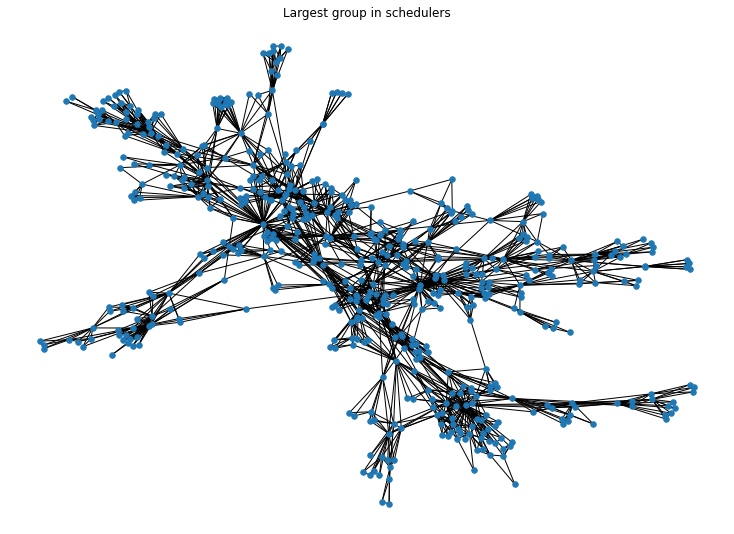

In [760]:
networkx.draw(largest_group, node_size=30)
print(len(largest_group.nodes))
plt.title("Largest group in schedulers")

## CMP year by year for biggest group

In [221]:
import itertools
def get_authors_from_year(year):
    authors_graph = {}

    publications_filtered_by_year = scheduling_df.loc[scheduling_df["year"].astype(int) == year]
    publications_filtered_by_year["authors"].apply(lambda authors_group: add_authors_to_graph(authors_group, authors_graph))
    authors_ngraph = networkx.Graph()
    for edge, weight in authors_graph.items():
        nodes = edge.split("_")
        node_x = int(nodes[0])
        node_y = int(nodes[1])
        authors_ngraph.add_edge(node_x, node_y, weight = weight)
    return authors_ngraph

In [222]:
authors_from_2011 = get_authors_from_year(2011)

In [223]:
largest_group_in_2011 = authors_from_2011.copy()
for i in authors_from_2011.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_2011.remove_node(i)

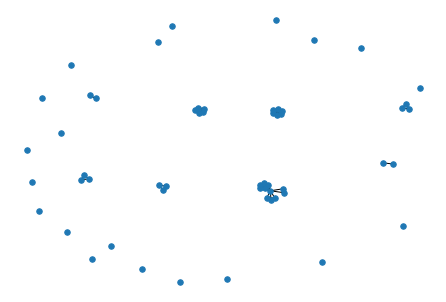

In [277]:
networkx.draw(largest_group_in_2011, node_size=30)

In [399]:
def plot_largest_group_from_year(year):
    authors_from_year = get_authors_from_year(year)
    largest_group_in_year = authors_from_year.copy()
    for i in authors_from_year.nodes:
        if not i in overlapping_triangles[0]:
            largest_group_in_year.remove_node(i)
    networkx.draw(largest_group, node_size=30, edgelist=largest_group_in_year.edges)

In [745]:
edges_up_to_previous_year = []
common_neighbors_list = []
graph_up_to_current_year = networkx.Graph()
import matplotlib.pyplot as plt

In [746]:
def get_common_neighbors_list(graph):
    common_neigbors_amount_list = []
    for node1, node2 in graph.edges:
        common_neigbors_amount_list.append(len(list(networkx.common_neighbors(graph, node1, node2))))
    return common_neigbors_amount_list
len(get_common_neighbors_list(authors_from_year))

def get_thickness(data, lower, upper):
    min_value = min(data)
    max_value = max(data)
    for i in range(0,len(data)):
        data[i] = ((data[i] - min_value)/max_value-min_value)*(upper-lower)+lower
    return data

# min(get_thickness(get_common_neighbors_list(authors_from_year), 0.05, 1))

plt.rcParams["figure.figsize"] = (10,7)

In [747]:
import colorsys
def get_colors(amount):
    hsv = [(x*1.0/amount, 1, 1) for x in range(0,amount)]
    rgb = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv))
    return rgb

get_colors(10)

[(1, 0.0, 0.0),
 (1, 0.6000000000000001, 0.0),
 (0.7999999999999998, 1, 0.0),
 (0.20000000000000018, 1, 0.0),
 (0.0, 1, 0.40000000000000036),
 (0.0, 1.0, 1),
 (0.0, 0.40000000000000036, 1),
 (0.1999999999999993, 0.0, 1),
 (0.8000000000000007, 0.0, 1),
 (1, 0.0, 0.5999999999999996)]

In [748]:
from collections import OrderedDict
def get_nodes_with_highest_centrality(graph):
    centerality_dict = networkx.degree_centrality(graph)
    return OrderedDict({node: centrality for node, centrality in sorted(centerality_dict.items(), key=lambda item: item[1])})

def get_top_centrality(graph):
    centerality_dict = networkx.degree_centrality(graph)
    return list(sorted(centerality_dict.items(), key=lambda x: x[1], reverse=True))
    
def get_node_colors(graph, top_nodes):
    colors = []
    top_colors = get_colors(len(top_nodes))
    for node in graph.nodes:
        is_in_top = False
        color_index = 0
        for i in range(0,len(top_nodes)):
            if top_nodes[i][0] == node:
                is_in_top = True
                color_index = i
        if is_in_top:
            colors.append(top_colors[color_index])
        else:
            colors.append((0,0,1))
    return colors

print(max(list(get_nodes_with_highest_centrality(largest_group).values())))
# get_node_colors(largest_group, get_top_centrality(largest_group, 10))
get_top_centrality(largest_group)[:10]

0.12037037037037038


[(2957, 0.12037037037037038),
 (7746, 0.10555555555555556),
 (5460, 0.08333333333333334),
 (1859, 0.07592592592592592),
 (37444, 0.07222222222222223),
 (7745, 0.06296296296296297),
 (14492, 0.05740740740740741),
 (8229, 0.05740740740740741),
 (14648, 0.05185185185185186),
 (17745, 0.05)]

In [749]:
import matplotlib.patches as mpatches
def get_legend(top_nodes):
    colors = get_colors(len(top_nodes))
    handles = []
    for i in range(0,len(top_nodes)):
        title = id_to_name_raw[index_to_id[top_nodes[i][0]]]["name"]
        value = top_nodes[i][1]
        handles.append(mpatches.Patch(color=colors[i], label="%s : %.4f" % (title, value)))
    return handles

Text(0.5, 1.0, 'Largest group in schedulers, 2011')

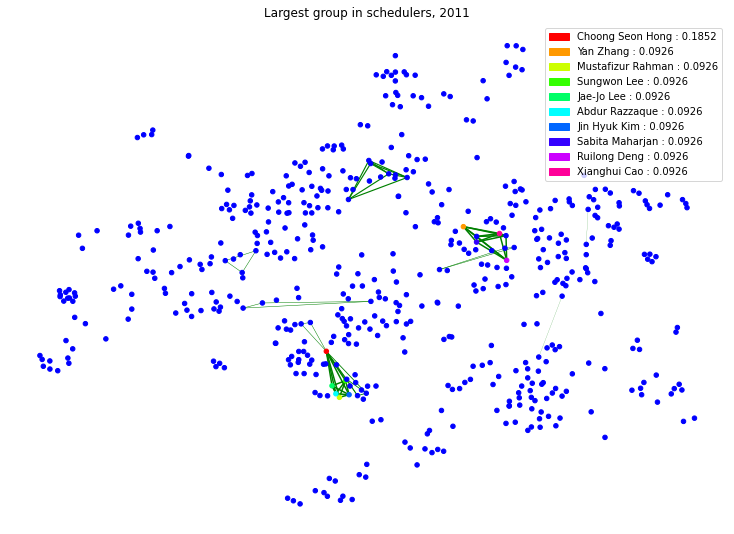

In [750]:
authors_from_year = get_authors_from_year(2011)
largest_group_in_year = authors_from_year.copy()
for i in authors_from_year.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_year.remove_node(i)
        
common_neighbors_list = common_neighbors_list + get_common_neighbors_list(largest_group_in_year)
widths = get_thickness(common_neighbors_list, 0.15, 1.5)

graph_up_to_current_year = networkx.compose(graph_up_to_current_year,largest_group_in_year)
top_centralities = get_top_centrality(graph_up_to_current_year)[:10] #(largest_group_in_year)[:10]
node_colors = get_node_colors(largest_group, top_centralities)

edges_to_draw = edges_up_to_previous_year + list(largest_group_in_year.edges)
colors = list(map(lambda x: "b", edges_up_to_previous_year)) + list(map(lambda x: "g", list(largest_group_in_year.edges)))
networkx.draw_spring(largest_group, node_size=20, edgelist=edges_to_draw, node_color=node_colors, edge_color=colors, label="Schedulers group, 2011", width=widths)
edges_up_to_previous_year = edges_to_draw
plt.legend(handles=get_legend(top_centralities))
plt.title("Largest group in schedulers, 2011")

Text(0.5, 1.0, 'Largest group in schedulers, 2012')

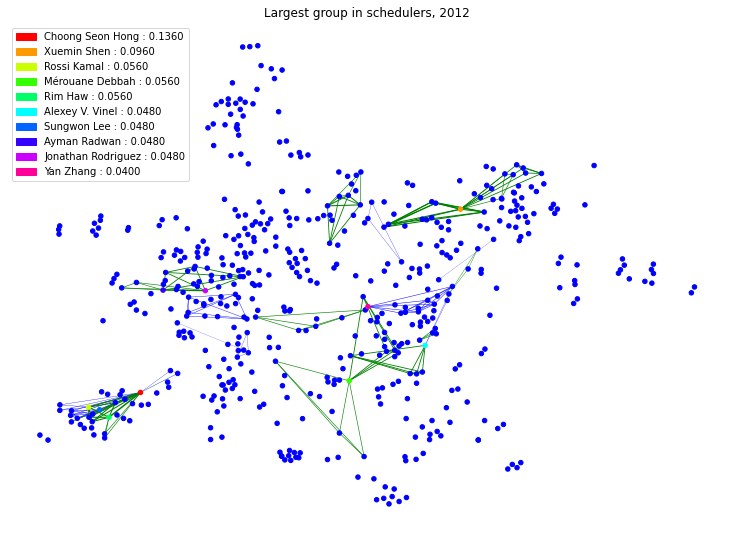

In [751]:
authors_from_year = get_authors_from_year(2012)
largest_group_in_year = authors_from_year.copy()
for i in authors_from_year.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_year.remove_node(i)
        
common_neighbors_list = common_neighbors_list + get_common_neighbors_list(largest_group_in_year)
widths = get_thickness(common_neighbors_list, 0.15, 1.5)

graph_up_to_current_year = networkx.compose(graph_up_to_current_year,largest_group_in_year)
top_centralities = get_top_centrality(graph_up_to_current_year)[:10] #(largest_group_in_year)[:10]
node_colors = get_node_colors(largest_group, top_centralities)
        
edges_to_draw = edges_up_to_previous_year + list(largest_group_in_year.edges)
colors = list(map(lambda x: "b", edges_up_to_previous_year)) + list(map(lambda x: "g", list(largest_group_in_year.edges)))
networkx.draw(largest_group, node_size=20, edgelist=edges_to_draw, node_color=node_colors, edge_color=colors, width=widths)
edges_up_to_previous_year = edges_to_draw
plt.legend(handles=get_legend(top_centralities))
plt.title("Largest group in schedulers, 2012")

Text(0.5, 1.0, 'Largest group in schedulers, 2013')

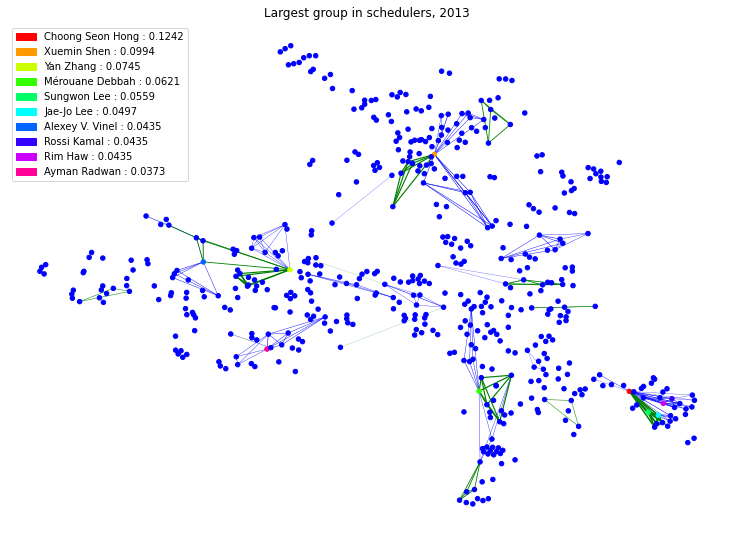

In [752]:
authors_from_year = get_authors_from_year(2013)
largest_group_in_year = authors_from_year.copy()
for i in authors_from_year.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_year.remove_node(i)
common_neighbors_list = common_neighbors_list + get_common_neighbors_list(largest_group_in_year)
widths = get_thickness(common_neighbors_list, 0.15, 1.5)

graph_up_to_current_year = networkx.compose(graph_up_to_current_year,largest_group_in_year)
top_centralities = get_top_centrality(graph_up_to_current_year)[:10] #(largest_group_in_year)[:10]
node_colors = get_node_colors(largest_group, top_centralities)

edges_to_draw = edges_up_to_previous_year + list(largest_group_in_year.edges)
colors = list(map(lambda x: "b", edges_up_to_previous_year)) + list(map(lambda x: "g", list(largest_group_in_year.edges)))
networkx.draw_spring(largest_group, node_size=20, edgelist=edges_to_draw, node_color=node_colors, edge_color=colors, width=widths)
edges_up_to_previous_year = edges_to_draw
plt.legend(handles=get_legend(top_centralities))
plt.title("Largest group in schedulers, 2013")

In [753]:
largest_group_in_year

Text(0.5, 1.0, 'Largest group in schedulers, 2014')

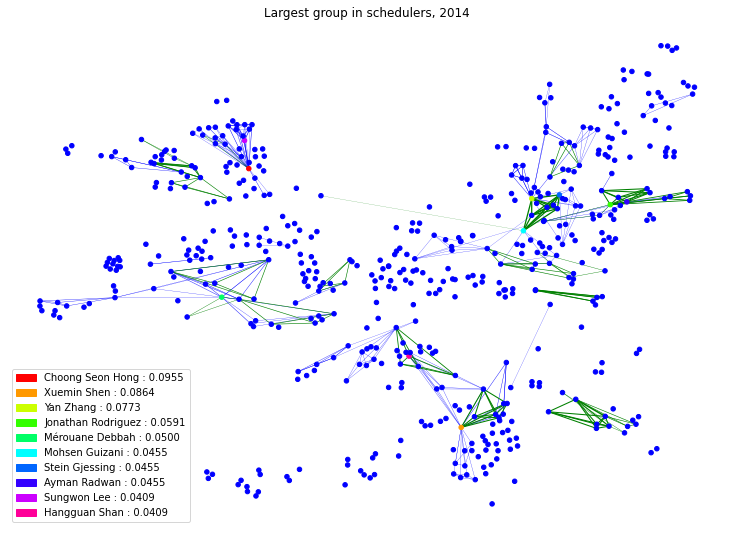

In [754]:
authors_from_year = get_authors_from_year(2014)
largest_group_in_year = authors_from_year.copy()
for i in authors_from_year.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_year.remove_node(i)
common_neighbors_list = common_neighbors_list + get_common_neighbors_list(largest_group_in_year)
widths = get_thickness(common_neighbors_list, 0.15, 1.5)

graph_up_to_current_year = networkx.compose(graph_up_to_current_year,largest_group_in_year)
top_centralities = get_top_centrality(graph_up_to_current_year)[:10] #(largest_group_in_year)[:10]
node_colors = get_node_colors(largest_group, top_centralities)

edges_to_draw = edges_up_to_previous_year + list(largest_group_in_year.edges)
colors = list(map(lambda x: "b", edges_up_to_previous_year)) + list(map(lambda x: "g", list(largest_group_in_year.edges)))
networkx.draw_spring(largest_group, node_size=20, edgelist=edges_to_draw, node_color=node_colors, edge_color=colors, width=widths)
edges_up_to_previous_year = edges_to_draw
plt.legend(handles=get_legend(top_centralities))
plt.title("Largest group in schedulers, 2014")

Text(0.5, 1.0, 'Largest group in schedulers, 2015')

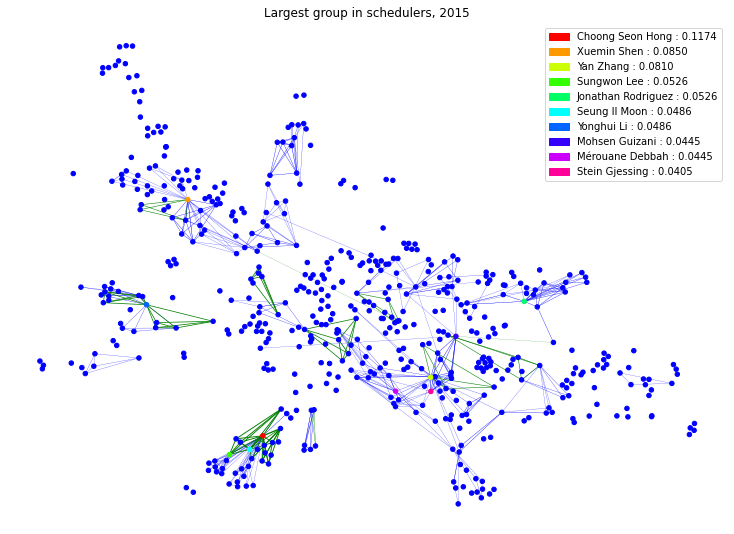

In [755]:
authors_from_year = get_authors_from_year(2015)
largest_group_in_year = authors_from_year.copy()
for i in authors_from_year.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_year.remove_node(i)
common_neighbors_list = common_neighbors_list + get_common_neighbors_list(largest_group_in_year)
widths = get_thickness(common_neighbors_list, 0.15, 1.5)

graph_up_to_current_year = networkx.compose(graph_up_to_current_year,largest_group_in_year)
top_centralities = get_top_centrality(graph_up_to_current_year)[:10] #(largest_group_in_year)[:10]
node_colors = get_node_colors(largest_group, top_centralities)

edges_to_draw = edges_up_to_previous_year + list(largest_group_in_year.edges)
colors = list(map(lambda x: "b", edges_up_to_previous_year)) + list(map(lambda x: "g", list(largest_group_in_year.edges)))
networkx.draw_spring(largest_group, node_size=20, edgelist=edges_to_draw, node_color=node_colors, edge_color=colors, width=widths)
edges_up_to_previous_year = edges_to_draw
plt.legend(handles=get_legend(top_centralities))
plt.title("Largest group in schedulers, 2015")

Text(0.5, 1.0, 'Largest group in schedulers, 2016')

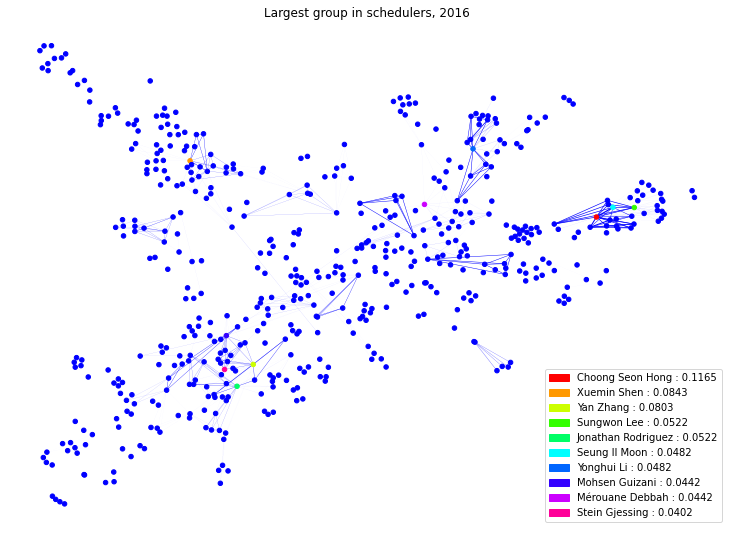

In [756]:
authors_from_year = get_authors_from_year(2016)
largest_group_in_year = authors_from_year.copy()
for i in authors_from_year.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_year.remove_node(i)
common_neighbors_list = common_neighbors_list + get_common_neighbors_list(largest_group_in_year)
widths = get_thickness(common_neighbors_list, 0.15, 1.5)     

graph_up_to_current_year = networkx.compose(graph_up_to_current_year,largest_group_in_year)
top_centralities = get_top_centrality(graph_up_to_current_year)[:10] #(largest_group_in_year)[:10]
node_colors = get_node_colors(largest_group, top_centralities)

edges_to_draw = edges_up_to_previous_year + list(largest_group_in_year.edges)
colors = list(map(lambda x: "b", edges_up_to_previous_year)) + list(map(lambda x: "g", list(largest_group_in_year.edges)))
networkx.draw_spring(largest_group, node_size=20, edgelist=edges_to_draw, node_color=node_colors, edge_color=colors, width=widths)
edges_up_to_previous_year = edges_to_draw
plt.legend(handles=get_legend(top_centralities))
plt.title("Largest group in schedulers, 2016")

Text(0.5, 1.0, 'Largest group in schedulers, 2017')

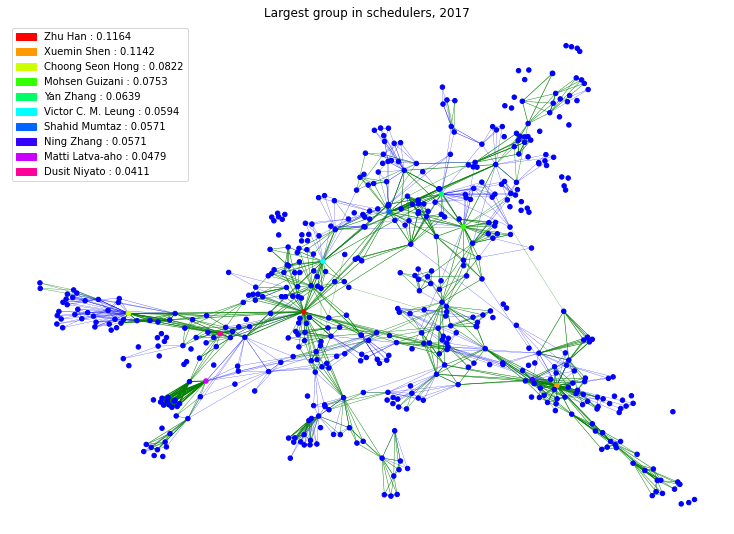

In [757]:
authors_from_year = get_authors_from_year(2017)
largest_group_in_year = authors_from_year.copy()
for i in authors_from_year.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_year.remove_node(i)

graph_up_to_current_year = networkx.compose(graph_up_to_current_year,largest_group_in_year)
top_centralities = get_top_centrality(graph_up_to_current_year)[:10] #(largest_group_in_year)[:10]
node_colors = get_node_colors(largest_group, top_centralities)

common_neighbors_list = common_neighbors_list + get_common_neighbors_list(largest_group_in_year)
widths = get_thickness(common_neighbors_list, 0.15, 1.5)      
edges_to_draw = edges_up_to_previous_year + list(largest_group_in_year.edges)
colors = list(map(lambda x: "b", edges_up_to_previous_year)) + list(map(lambda x: "g", list(largest_group_in_year.edges)))
networkx.draw_spring(largest_group, node_size=20, edgelist=edges_to_draw, node_color=node_colors, edge_color=colors, width=widths)
edges_up_to_previous_year = edges_to_draw
plt.legend(handles=get_legend(top_centralities))
plt.title("Largest group in schedulers, 2017")

Text(0.5, 1.0, 'Largest group in schedulers, 2018')

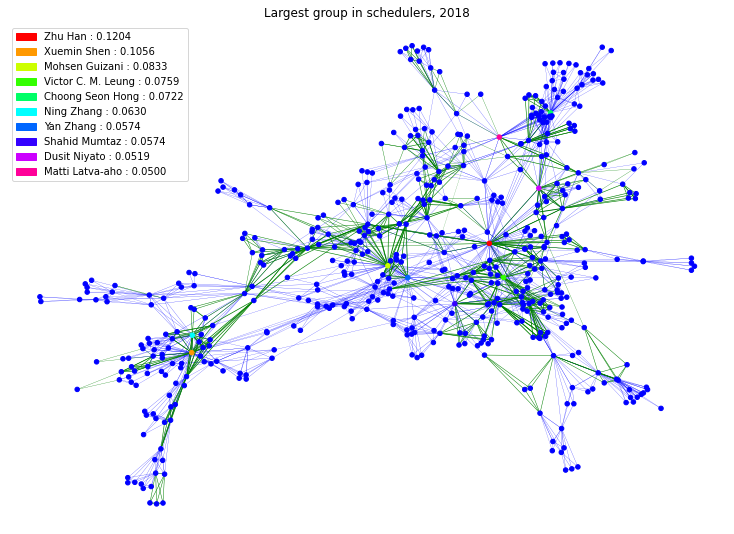

In [758]:
authors_from_year = get_authors_from_year(2018)
largest_group_in_year = authors_from_year.copy()
for i in authors_from_year.nodes:
    if not i in overlapping_triangles[0]:
        largest_group_in_year.remove_node(i)

graph_up_to_current_year = networkx.compose(graph_up_to_current_year,largest_group_in_year)
top_centralities = get_top_centrality(graph_up_to_current_year)[:10] #(largest_group_in_year)[:10]
node_colors = get_node_colors(largest_group, top_centralities)

common_neighbors_list = common_neighbors_list + get_common_neighbors_list(largest_group_in_year)
widths = get_thickness(common_neighbors_list, 0.15, 1.5)   
edges_to_draw = edges_up_to_previous_year + list(largest_group_in_year.edges)
colors = list(map(lambda x: "b", edges_up_to_previous_year)) + list(map(lambda x: "g", list(largest_group_in_year.edges)))
networkx.draw_spring(largest_group, node_size=20, edgelist=edges_to_draw, node_color=node_colors, edge_color=colors, width=widths)
edges_up_to_previous_year = edges_to_draw
plt.legend(handles=get_legend(top_centralities))
plt.title("Largest group in schedulers, 2018")

## Basic metrics for largest group

In [761]:
betweenness = pandas.DataFrame.from_dict(betweenness_centrality(largest_group), orient='index', columns=["Betweenness"])

In [762]:
degree = pandas.DataFrame.from_dict(degree_in_graph(authors_ngraph), orient='index', columns=["Degree"])

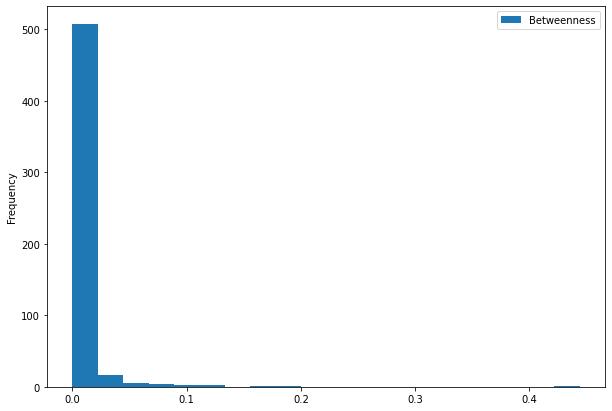

In [763]:
betweenness.plot.hist(bins=20)

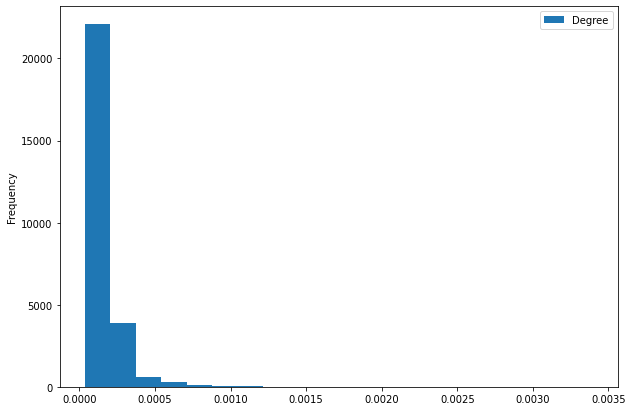

In [764]:
degree.plot.hist(bins=20)

In [765]:
sorted_by_degree = degree.sort_values(by="Degree")
ids_of_most_active_authors = list(map(lambda x: index_to_id[x], sorted_by_degree[:10].index))
names_of_most_active_authors = list(map(lambda x: id_to_name_raw[x], ids_of_most_active_authors))
for author in names_of_most_active_authors:
    print(" - " + author["name"])

 - Seung Hyong Rhee
 - Marwan Krunz
 - Mahamed Abdelmadjid Allali
 - Zoulikha Mekkakia Maaza
 - Kyohei Sumikawa
 - N. Ozlem Unverdi
 - Cenk Catalbas
 - Hiromasa Habuchi
 - P. Auguste Randriamitantsoa
 - N.Manda Vy Ravonimanantsoa


In [766]:
sorted_by_betweenness = betweenness.sort_values(by="Betweenness")
ids_of_most_active_authors = list(map(lambda x: index_to_id[x], sorted_by_betweenness[:10].index))
names_of_most_active_authors = list(map(lambda x: id_to_name_raw[x], ids_of_most_active_authors))
for author in names_of_most_active_authors:
    print(" - " + author["name"])

 - Weidang Lu
 - Taha Belkhouja
 - Prabodini Semasinghe
 - Yaodong Zhang
 - Xiaoyi Tao
 - Ali Munir
 - Heng Qi
 - Wenxin Li
 - Deke Guo
 - Xin Liu
